In [ ]:
best_result = 5
kmeans = kmeans_results.get(best_result)


final_df_array = df_jobs['embeddings_RNN_Glove_Bert_Flair'].to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

## Perform clustering and topic modelling on job descriptions of various data science related jobs posted on Indeed.com

## Import packages

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import keras.layers as layers
from keras.models import Model
from keras import backend as K
import nltk
from nltk.corpus import stopwords

from sklearn.cluster import KMeans 
from sklearn import cluster
from sklearn.cluster import AgglomerativeClustering
np.random.seed(10)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Upload dataset to Google Collab

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving job_scrapping_indeed.csv to job_scrapping_indeed (1).csv


## Import the dataset

In [ ]:
import io
df_jobs = pd.read_csv(io.BytesIO(uploaded['job_scrapping_indeed.csv']))
# Dataset is now stored in a Pandas Dataframe

NameError: ignored

In [ ]:
df_jobs.head()

,Unnamed: 0,job_title,company_name,description
0,1,Sr. Clinical Data Analyst,Makrocare,makrocare is an expert strategic development a...
1,2,Senior Scientist,Sandoz,your key responsibilities your responsibiliti...
2,3,"Deputy Director, Data Fabric Engineer and Auto...",PepsiCo,auto req id 3 br job description design a...
3,4,Lead Data Scientist/Manager Data Scientist,CoreCompete,you will be primarily responsible for the desi...
4,5,Data Analyst,GE Appliances,job location hyderabad sal in job posting ti...


### Pre-process the job descriptions

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def normalize_text(text):
    text = re.sub("[^A-Za-z0-9 ]+", "", text)       #remove puntuations
    regex = r"(\d(?:\.|\))\s+)|([a-z]\)\s+)|(•\s+)|([A-Z]\.\s+)|((?:[IVX]|[ivx])+(?:\.|\))\s+)"
    text = text.strip().replace("\n","")  
    text = re.sub(regex, "", text)                   # remove all bullet points
    words = text.split()                             # Filter out any stop words
    text_without_stops = ""
    for word in words:
        if not word in stop_words:
            text_without_stops = text_without_stops + word + " "
    return text_without_stops

In [ ]:
df_jobs['description_'] = df_jobs.apply(lambda row: normalize_text(row['description']),axis=1)

In [ ]:
df_jobs.head()

,Unnamed: 0,job_title,company_name,description,description_
0,1,Sr. Clinical Data Analyst,Makrocare,makrocare is an expert strategic development a...,makrocare expert strategic development commerc...
1,2,Senior Scientist,Sandoz,your key responsibilities your responsibiliti...,key responsibilities responsibilities include ...
2,3,"Deputy Director, Data Fabric Engineer and Auto...",PepsiCo,auto req id 3 br job description design a...,auto req id 3 br job description design implem...
3,4,Lead Data Scientist/Manager Data Scientist,CoreCompete,you will be primarily responsible for the desi...,primarily responsible design development opera...
4,5,Data Analyst,GE Appliances,job location hyderabad sal in job posting ti...,job location hyderabad sal job posting title d...


## Downloading the models

Flair Model

In [ ]:
!pip install git+https://github.com/zalandoresearch/flair.git

In [ ]:
import flair
print(flair.__version__)

0.5.1


**Transformers (Universal sentence encoder)**

In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


## Embedings for the job descriptions

**Using Flair**

We will use a multiple word embeddings (**BERT, GLOVE and some of the recommended Flair word embeddings**) and run an **RNN** over them to get the sentence embeddings.

In [ ]:
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentRNNEmbeddings, BertEmbeddings
from flair.models import TextClassifier
from flair.data import Sentence

word_embeddings = [WordEmbeddings('glove'),  FlairEmbeddings('news-backward-fast'), FlairEmbeddings('news-forward-fast')]  #BertEmbeddings('bert-base-uncased'),
document_embeddings = DocumentRNNEmbeddings(word_embeddings, hidden_size=512, reproject_words=True, reproject_words_dimension=256)

In [ ]:
def get_glove_bert_flair_embeddings(input):
  try:
    sentence = Sentence(input)
    document_embeddings.embed(sentence)         # embed the sentence with our document embedding
    return sentence.get_embedding().tolist()
  except:
    print(input)

In [ ]:
print(get_glove_bert_flair_embeddings('key responsibilities demonstrate practically useful applications quantum computing machine learning iterative development testing quantum algorithms machine learning pipelines leading edge rigetti systems perform research intersection machine learning quantum computing prototype benchmark new methods simulators advanced quantum hardware versus state art classical implementations collaborate diverse subject matter experts quantum verification scientists establish practical research pathways towards quantum advantage collaborate application scientists software engineers realize scalable production quality implementations key insights frameworks evaluate scope lead research programs external partners academia industry government ms phd physics electrical engineering computer science related field post graduate experience industry equivalent experience experience following valued neural networks reinforcement learning generative adversarial networks probabilistic modelling programming experience following valued training quantum circuits generate features ii generate distributions iii perform classification quantum algorithms broadly particularly variational algorithms demonstrated ability develop test quantum algorithms program quantum processors experience background writing complex production quality software emphasis mathematical scientific software including deploying production machine learning workflows excellent technical communication leadership skills experience delivering high impact research results continue navigate unprecedented times committed prioritizing health safety employees adopted virtual interview process position remote optional based either uk united states benefits perks rigetti seeks individuals motivated grand challenges opportunity make meaningful impact exciting quantum computing space long term visionaries offer employees opportunities continuous personal professional growth advance mission help solve humanity important pressing problems support financial success health employees families offer following benefits addition competitive base salary k plangenerous equity grant coverage medical kaiser anthem blue cross guardian dental guardian visionanthem blue cross life insurance cost employeeopportunities additional performance based equity grants bonuses help employees bring best selves work also offer various perks support individual perform highest level foster work life balance full time exempt employees eligible unlimited pto soon join first year also eligible take annual 3 week paid sabbaticalfitness activity gym membership reimbursement week paid parental leavefsa commuter benefitsemployment assistance program eap flexible work schedule continue grow company prioritize applicants created thoughtful application share vision passion quantum computing regret hire every applicant keep applications file years reach good fit future opportunity rigetti rigetti computing mission build worlds powerful computers based berkeley fremont ca scientists engineers builders visionaries believe quantum computing going significantly affect health care treat disease generate energy feed humanity design fabricate quantum circuits deploy quantum computers available online engineers build full stack technologies integrated machines including cryogenic hardware microwave circuitry advanced analog digital control modules software stack provides worlds advanced sdk runtime environment quantum computers quantum computer available product quantum cloud services worlds first full stack programming execution environment quantum classical computing founded chad rigetti 3 today employ people see job want apply keep touch right role opens future export licensing compliance position may require access information protected us export control laws regulations including international traffic arms regulations itar export administration regulations ear please note offer employment may conditioned authorization receive software technology controlled us export control laws regulations without sponsorship export license order ensure compliance rigetti must determine us citizenship us visa immigration status prospective applicants position citizenship information provided reviewed solely export control compliance purposes applicants authorized receive export controlled items software technology information considered position citizenship information handled accordance rigettis policies prohibiting discrimination based upon classifications protected federal state local law rigetti committed full compliance applicable anti discrimination laws equal opportunity employer value diversity company strive create inclusive work environment discriminate basis race religion color national origin gender sexual orientation age marital status veteran status disability status '))

[0.004579082131385803, -0.06482706218957901, 0.0021647512912750244, -0.005893426015973091, -0.15009266138076782, 0.050960130989551544, -0.06293869763612747, 0.004619000479578972, -0.09643737971782684, -0.08764258027076721, -0.07296831160783768, -0.04188285768032074, -0.10432997345924377, -0.09349438548088074, -0.0792304277420044, 0.04227391257882118, 0.14990553259849548, 0.0002768188714981079, -0.02645355649292469, 0.0613522008061409, -0.13381563127040863, 0.020315399393439293, -0.027867451310157776, -0.02806537225842476, -0.07038889825344086, -0.10003060102462769, 0.012813829816877842, -0.19758425652980804, -0.1311337798833847, -0.01803203485906124, -0.005122736096382141, -0.04027484729886055, -0.08546479046344757, 0.03744520619511604, -0.0277499221265316, -0.09317310899496078, -0.057848431169986725, -0.008619515225291252, 0.014158557169139385, -0.04723765701055527, -0.045862436294555664, -0.04608188569545746, -0.16228757798671722, 0.09692531079053879, -0.00865393690764904, -0.0941092

In [ ]:
df_jobs['embeddings_RNN_Glove_Bert_Flair'] = df_jobs.apply(lambda row: get_glove_bert_flair_embeddings(row["description_"]), axis=1)

In [ ]:
df_jobs.head()

,Unnamed: 0,job_title,company_name,description,description_,embeddings_RNN_Glove_Bert_Flair
0,1,Sr. Clinical Data Analyst,Makrocare,makrocare is an expert strategic development a...,makrocare expert strategic development commerc...,"[-0.10001186281442642, 0.12235163897275925, -0..."
1,2,Senior Scientist,Sandoz,your key responsibilities your responsibiliti...,key responsibilities responsibilities include ...,"[-0.052625253796577454, 0.14464233815670013, 0..."
2,3,"Deputy Director, Data Fabric Engineer and Auto...",PepsiCo,auto req id 3 br job description design a...,auto req id 3 br job description design implem...,"[-0.04244771972298622, 0.13476264476776123, 0...."
3,4,Lead Data Scientist/Manager Data Scientist,CoreCompete,you will be primarily responsible for the desi...,primarily responsible design development opera...,"[-0.050197187811136246, 0.17486019432544708, -..."
4,5,Data Analyst,GE Appliances,job location hyderabad sal in job posting ti...,job location hyderabad sal job posting title d...,"[-0.06858900934457779, 0.16449515521526337, 0...."


**Using Transformers**

In [ ]:
def get_transformers_embeddings(input):
  return model(input)

In [ ]:
df_jobs['embeddings_transformers'] = df_jobs.apply(lambda row: np.array(get_transformers_embeddings([row["description_"]])).tolist()[0], axis=1)

In [ ]:
df_jobs.head()

,Unnamed: 0,job_title,company_name,description,description_,embeddings_RNN_Glove_Bert_Flair,embeddings_transformers
0,1,Sr. Clinical Data Analyst,Makrocare,makrocare is an expert strategic development a...,makrocare expert strategic development commerc...,"[-0.10001186281442642, 0.12235163897275925, -0...","[0.006804747972637415, -0.05359392240643501, 0..."
1,2,Senior Scientist,Sandoz,your key responsibilities your responsibiliti...,key responsibilities responsibilities include ...,"[-0.052625253796577454, 0.14464233815670013, 0...","[0.04652365669608116, -0.04656030237674713, -0..."
2,3,"Deputy Director, Data Fabric Engineer and Auto...",PepsiCo,auto req id 3 br job description design a...,auto req id 3 br job description design implem...,"[-0.04244771972298622, 0.13476264476776123, 0....","[0.03358707204461098, -0.04933454468846321, 0...."
3,4,Lead Data Scientist/Manager Data Scientist,CoreCompete,you will be primarily responsible for the desi...,primarily responsible design development opera...,"[-0.050197187811136246, 0.17486019432544708, -...","[0.04550231620669365, -0.04550237953662872, -0..."
4,5,Data Analyst,GE Appliances,job location hyderabad sal in job posting ti...,job location hyderabad sal job posting title d...,"[-0.06858900934457779, 0.16449515521526337, 0....","[0.0445396862924099, -0.04670754820108414, -0...."


In [ ]:
!pip3 install pytorch_pretrained_bert

In [ ]:
from pytorch_pretrained_bert import BertTokenizer
tokeniser = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case = True)
from pytorch_pretrained_bert import BertModel
bert = BertModel.from_pretrained('bert-large-uncased')
import torch

tokenised_sentence = ["[CLS]"] + tokeniser.tokenize('key responsibilities demonstrate practically useful applications quantum computing machine learning iterative development testing quantum algorithms machine learning pipelines leading edge rigetti systems perform research intersection machine learning quantum computing prototype benchmark new methods simulators advanced quantum hardware versus state art classical implementations collaborate diverse subject matter experts quantum verification scientists establish practical research pathways towards quantum advantage collaborate application scientists software engineers realize scalable production quality implementations key insights frameworks evaluate scope lead research programs external partners academia industry government ms phd physics electrical engineering computer science related field post graduate experience industry equivalent experience experience following valued neural networks reinforcement learning generative adversarial networks probabilistic modelling programming experience following valued training quantum circuits generate features ii generate distributions iii perform classification quantum algorithms broadly particularly variational algorithms demonstrated ability develop test quantum algorithms program quantum processors experience background writing complex production quality software emphasis mathematical scientific software including deploying production machine learning workflows excellent technical communication leadership skills experience delivering high impact research results continue navigate unprecedented times committed prioritizing health safety employees adopted virtual interview process position remote optional based either uk united states benefits perks rigetti seeks individuals motivated grand challenges opportunity make meaningful impact exciting quantum computing space long term visionaries offer employees opportunities continuous personal professional growth advance mission help solve humanity important pressing problems support financial success health employees families offer following benefits addition competitive base salary k plangenerous equity grant coverage medical kaiser anthem blue cross guardian dental guardian visionanthem blue cross life insurance cost employeeopportunities additional performance based equity grants bonuses help employees bring best selves work also offer various perks support individual perform highest level foster work life balance full time exempt employees eligible unlimited pto soon join first year also eligible take annual 3 week paid sabbaticalfitness activity gym membership reimbursement week paid parental leavefsa commuter benefitsemployment assistance program eap flexible work schedule continue grow company prioritize applicants created thoughtful application share vision passion quantum computing regret hire every applicant keep applications file years reach good fit future opportunity rigetti rigetti computing mission build worlds powerful computers based berkeley fremont ca scientists engineers builders visionaries believe quantum computing going significantly affect health care treat disease generate energy feed humanity design fabricate quantum circuits deploy quantum computers available online engineers build full stack technologies integrated machines including cryogenic hardware microwave circuitry advanced analog digital control modules software stack provides worlds advanced sdk runtime environment quantum computers quantum computer available product quantum cloud services worlds first full stack programming execution environment quantum classical computing founded chad rigetti 3 today employ people see job want apply keep touch right role opens future export licensing compliance position may require access information protected us export control laws regulations including international traffic arms regulations itar export administration regulations ear please note offer employment may conditioned authorization receive software technology controlled us export control laws regulations without sponsorship export license order ensure compliance rigetti must determine us citizenship us visa immigration status prospective applicants position citizenship information provided reviewed solely export control compliance purposes applicants authorized receive export controlled items software technology information considered position citizenship information handled accordance rigettis policies prohibiting discrimination based upon classifications protected federal state local law rigetti committed full compliance applicable anti discrimination laws equal opportunity employer value diversity company strive create inclusive work environment discriminate basis race religion color national origin gender sexual orientation age marital status veteran status disability status ') +  ["[SEP]"]
tokens_tensor = torch.tensor([tokeniser.convert_tokens_to_ids(tokenised_sentence)])
segments_tensor = torch.tensor([[0 for _ in range(len(tokenised_sentence))]])
encoded_layers, _ = bert(tokens_tensor, segments_tensor)
paragraph_vector = encoded_layers[0][-1][0].detach().numpy()

**Now that we have got the embeddings for each job description, we will cluster these jobs into different clusters.**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving job_clustering_final.csv to job_clustering_final (2).csv


In [31]:
import io
df_jobs = pd.read_csv(io.BytesIO(uploaded['job_clustering_final.csv']))

In [32]:
df_jobs.head()

,Unnamed: 0,Unnamed: 0.1,job_title,company_name,description,description_,embeddings_RNN_Glove_Bert_Flair,embeddings_transformers,clusters_RNN_Glove_Bert_Flair,clusters_transformers,clusters_RNN_Glove_Bert_Flair_Kmeans
0,0,1,Sr. Clinical Data Analyst,Makrocare,makrocare is an expert strategic development a...,makrocare expert strategic development commerc...,"[-0.10001186281442642, 0.12235163897275925, -0...","[0.006804747972637415, -0.05359392240643501, 0...",0,2,6
1,1,2,Senior Scientist,Sandoz,your key responsibilities your responsibiliti...,key responsibilities responsibilities include ...,"[-0.052625253796577454, 0.14464233815670013, 0...","[0.04652365669608116, -0.04656030237674713, -0...",0,1,6
2,2,3,"Deputy Director, Data Fabric Engineer and Auto...",PepsiCo,auto req id 3 br job description design a...,auto req id 3 br job description design implem...,"[-0.04244771972298622, 0.13476264476776123, 0....","[0.03358707204461098, -0.04933454468846321, 0....",0,2,1
3,3,4,Lead Data Scientist/Manager Data Scientist,CoreCompete,you will be primarily responsible for the desi...,primarily responsible design development opera...,"[-0.050197187811136246, 0.17486019432544708, -...","[0.04550231620669365, -0.04550237953662872, -0...",0,1,6
4,4,5,Data Analyst,GE Appliances,job location hyderabad sal in job posting ti...,job location hyderabad sal job posting title d...,"[-0.06858900934457779, 0.16449515521526337, 0....","[0.0445396862924099, -0.04670754820108414, -0....",0,1,6


### Clustering of job descriptions

Let us use **Agglomerative Clustering with Ward affinity** from scikit-learn to perform clustering

Before that, let us select the number of clusters to start with. We will use k-means to find this number.

**using Glove, Flair embeddings**

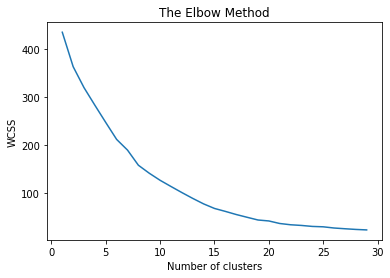

In [ ]:
wcss = [] 

for i in range(1, 30): 
  kmeans = KMeans(n_clusters=i, init = 'k-means++', random_state = 42 ) 
  kmeans.fit(df_jobs['embeddings_RNN_Glove_Bert_Flair'].tolist()) 
  wcss.append(kmeans.inertia_) 

plt.plot(range( 1,30), wcss) 
plt.title( 'The Elbow Method' ) 
plt.xlabel('Number of clusters') 
plt.ylabel('WCSS') 
plt.show() 

**using transformers embeddings**

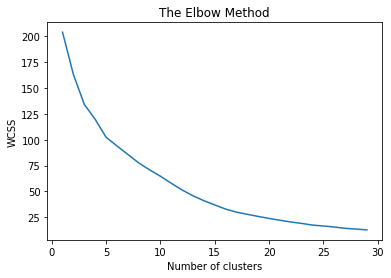

In [ ]:
wcss = [] 

for i in range(1, 30): 
  kmeans = KMeans(n_clusters=i, init = 'k-means++', random_state = 42 ) 
  kmeans.fit(df_jobs['embeddings_transformers'].tolist()) 
  wcss.append(kmeans.inertia_) 

plt.plot(range( 1,30), wcss) 
plt.title( 'The Elbow Method' ) 
plt.xlabel('Number of clusters') 
plt.ylabel('WCSS') 
plt.show() 

In both the graphs, we can see the slope is drastically diminissing after 5-7. **Let us start by the number 7!**

**Clustering using the Glove + Flair embedding**

In [ ]:
N_CLUSTERS = 7
# WARD CLUSTER
ward = AgglomerativeClustering(n_clusters=N_CLUSTERS,
                               affinity='euclidean',
                               linkage='ward')
pred_ward_rnn_glove_bert_flair = ward.fit_predict(df_jobs['embeddings_RNN_Glove_Bert_Flair'].tolist())
df_jobs['clusters_RNN_Glove_Bert_Flair'] = pred_ward_rnn_glove_bert_flair

In [ ]:
kmeans_clustering = KMeans(n_clusters = N_CLUSTERS, init='k-means++');
idx = kmeans_clustering.fit_predict(df_jobs['embeddings_RNN_Glove_Bert_Flair'].tolist())
df_jobs['clusters_RNN_Glove_Bert_Flair_Kmeans'] = idx

In [70]:
N_CLUSTERS = 12
# WARD CLUSTER
import ast

ward = AgglomerativeClustering(n_clusters=N_CLUSTERS,
                               affinity='euclidean',
                               linkage='ward')
pred_ward_rnn_glove_bert_flair = ward.fit_predict([ast.literal_eval(df_jobs['embeddings_RNN_Glove_Bert_Flair'][ind]) for ind in df_jobs.index])
df_jobs['clusters_RNN_Glove_Bert_Flair12'] = pred_ward_rnn_glove_bert_flair

**Clustering using the Transformers embeddings**

In [ ]:
pred_ward_transformers = ward.fit_predict(df_jobs['embeddings_transformers'].tolist())
df_jobs['clusters_transformers'] = pred_ward_transformers

In [72]:
pred_ward_transformers = ward.fit_predict([ast.literal_eval(df_jobs['embeddings_transformers'][ind]) for ind in df_jobs.index])
df_jobs['clusters_transformers12'] = pred_ward_transformers

### Let us analyse these clusters.

Let us find the top words and phrases (uni- and bi-grams) in each cluster with the highest TF-IDF scores. This will help us to find terms which appear a lot in one cluster and do not appear much in other clusters

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
def get_top_words(documents, top_n):
  '''
  function to get top tf-idf words and phrases
  '''
  vectoriser = TfidfVectorizer(ngram_range=(1, 2),
                               max_df=0.5)            # doc frequency is 50% to filter out very common terms
  tfidf_matrix = vectoriser.fit_transform(documents)
  feature_names = vectoriser.get_feature_names()
  df_tfidf = pd.DataFrame()
  for doc in range(len(documents)):
    words = []
    scores = []
    feature_index = tfidf_matrix[doc,:].nonzero()[1]
    tfidf_scores = zip(feature_index, [tfidf_matrix[doc, x] for x in feature_index])
    for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
      words.append(w)
      scores.append(s)
    df_temp = pd.DataFrame(data={"word":words, "score":scores})
    df_temp = df_temp.sort_values("score",ascending=False).head(top_n)
    df_temp["topic"] = doc
    df_tfidf = df_tfidf.append(df_temp)
  return df_tfidf

In [85]:
def plot_important_terms_in_clusters_using_tfidf(embedding_algorithm, N_CLUSTERS):
  topic_docs = []
  # group text into cluster-documents
  for topic in range(N_CLUSTERS):
      topic_docs.append(' '.join(df_jobs[df_jobs[embedding_algorithm]==topic]['description_']))
  df_tfidf = get_top_words(topic_docs, 15)

  for i in range(N_CLUSTERS):
    print("common words in cluster {}:".format(i+1))
    words = df_tfidf[df_tfidf['topic']==i]['word']
    score = df_tfidf[df_tfidf['topic']==i]['score']   
    plt.figure(figsize=(20,5))
    plt.bar(words,score)
    plt.xticks(rotation=45)
    plt.pause(0.0001)

**Plot top words in clusters formed using the Glove+Flair embeddings**

common words in cluster 1:


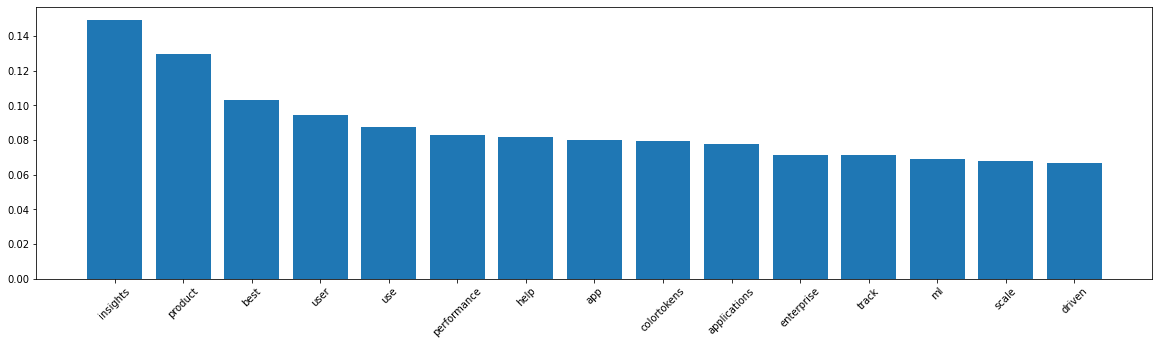

common words in cluster 2:


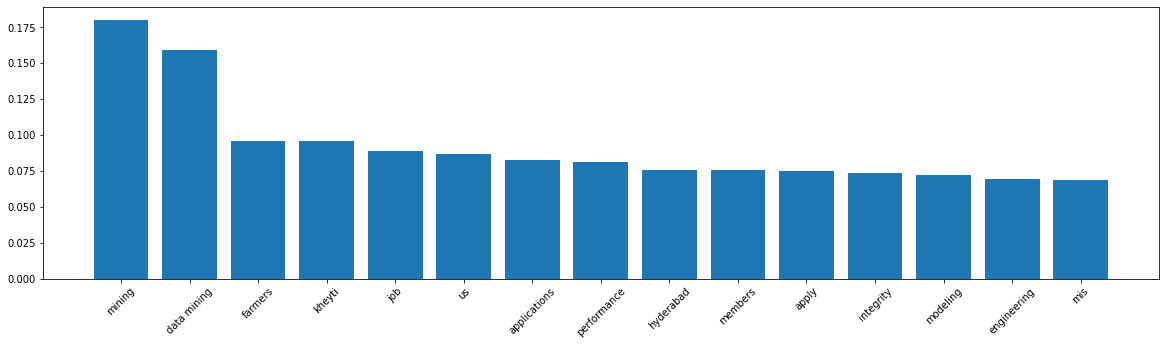

common words in cluster 3:


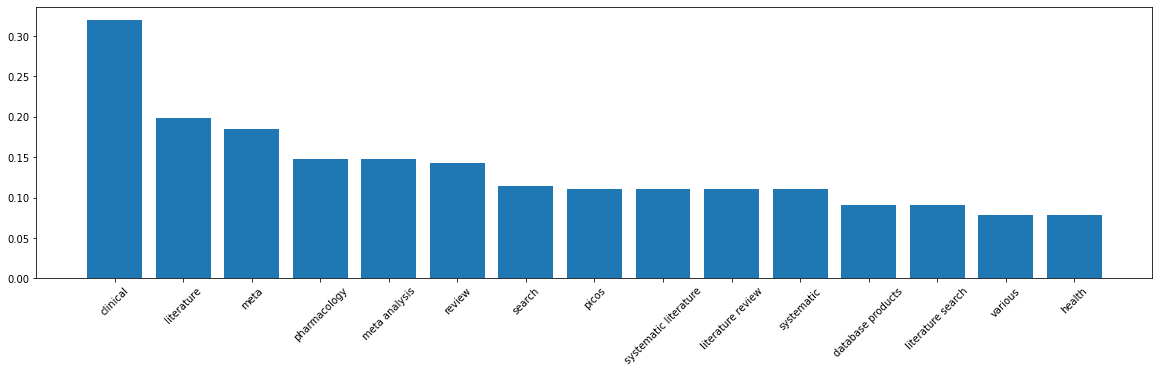

common words in cluster 4:


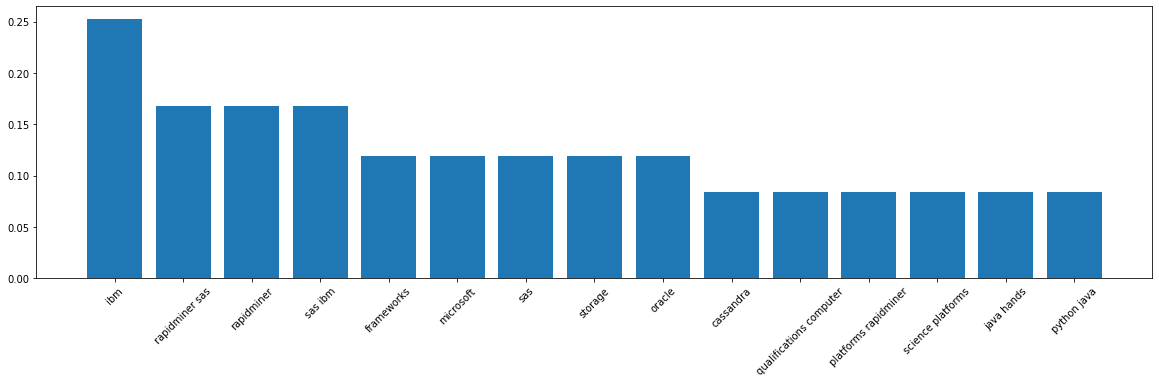

common words in cluster 5:


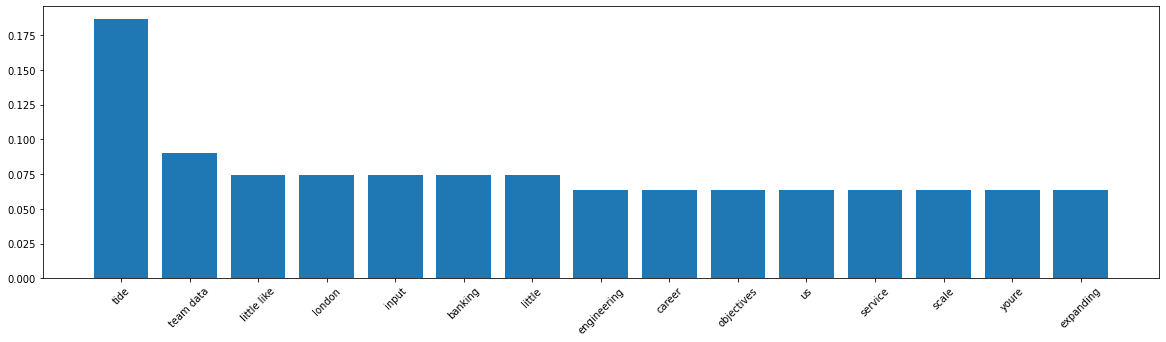

common words in cluster 6:


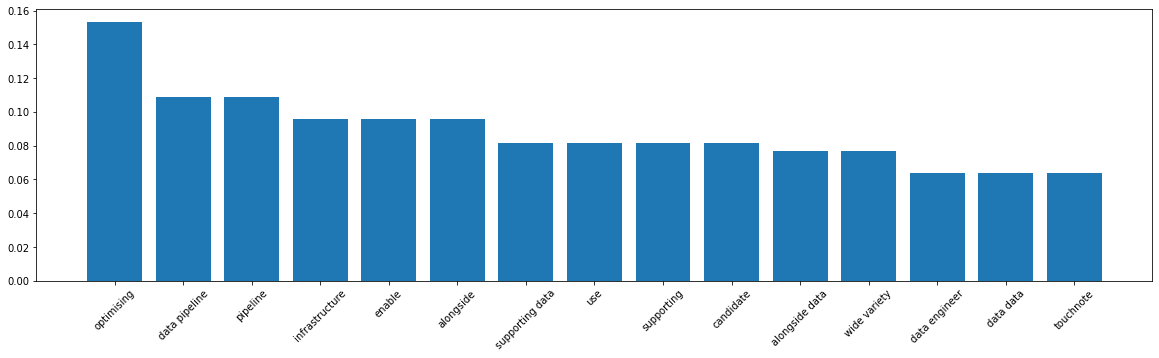

common words in cluster 7:


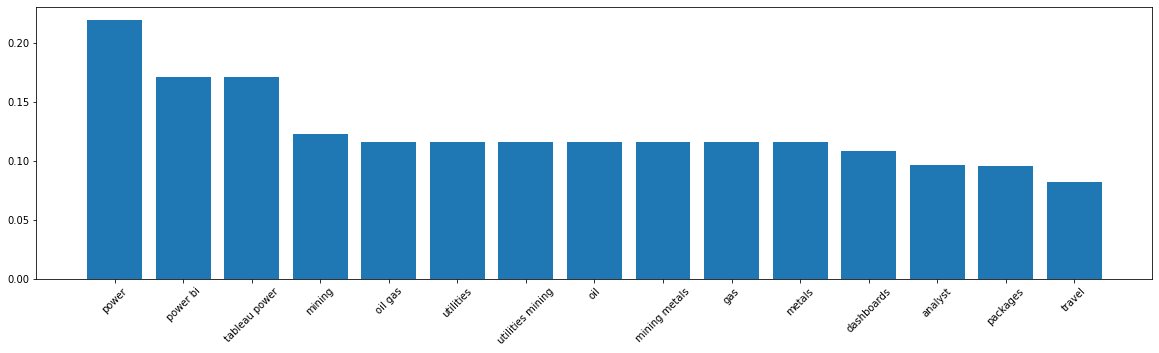

In [86]:
plot_important_terms_in_clusters_using_tfidf('clusters_RNN_Glove_Bert_Flair', 7)

**1) As can be seen from the plots, Cluster 4 clearly deals with data mining and various tools like rapidminer, sas, cassandra, oracle, microsoft and some programming languages like python and java**

**2) Cluster 3 is a mix of pharma, health and literature**

**3) Cluster 6 is about data pipelines, infrastructure, optmimisation**

**4) Cluster 7 speaks about analytics in general using terms like power bi, tableau, dashboards, analyst mostly in oil and gas, metals and travel domain**

**5) But overal the clusters have some overlapping.**

**Plot top words in clusters formed using Transformers embeddings**

common words in cluster 1:


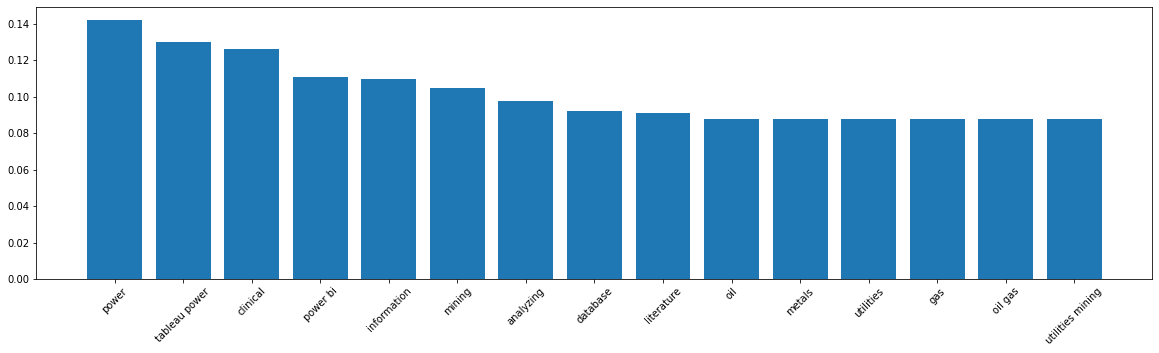

common words in cluster 2:


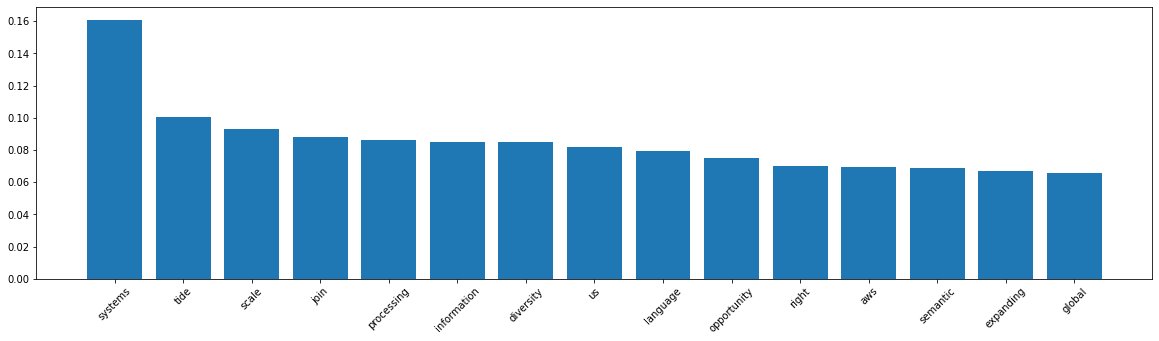

common words in cluster 3:


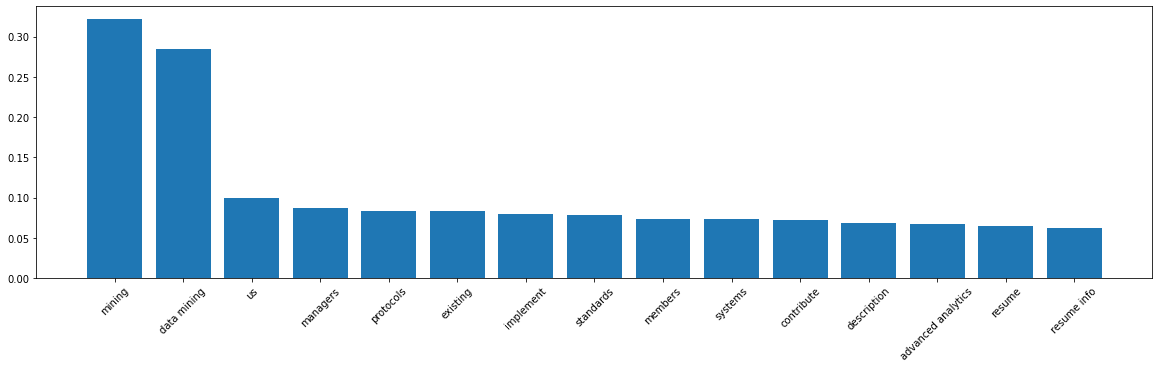

common words in cluster 4:


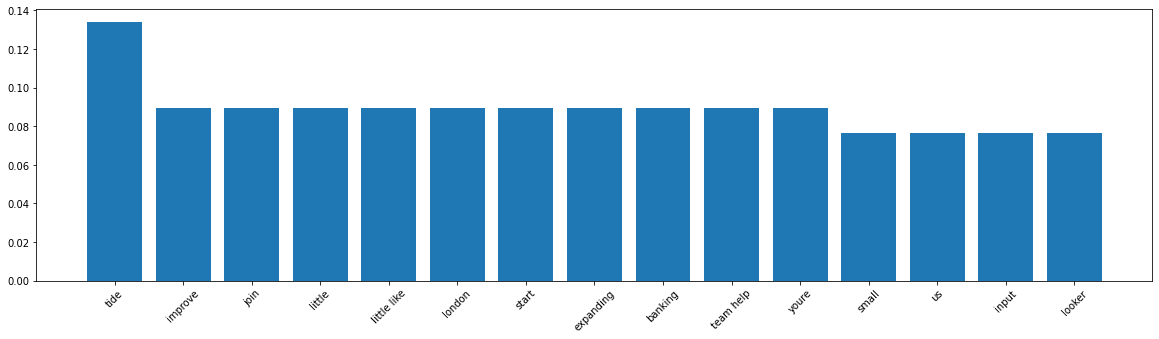

common words in cluster 5:


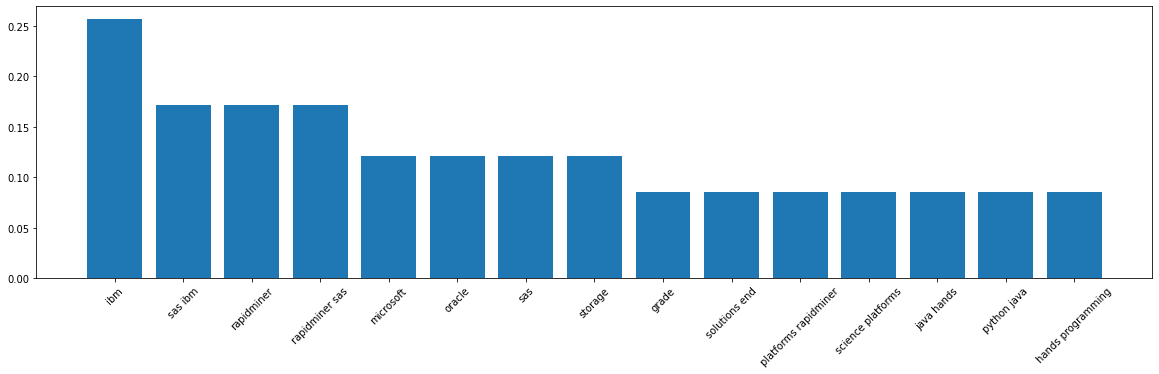

common words in cluster 6:


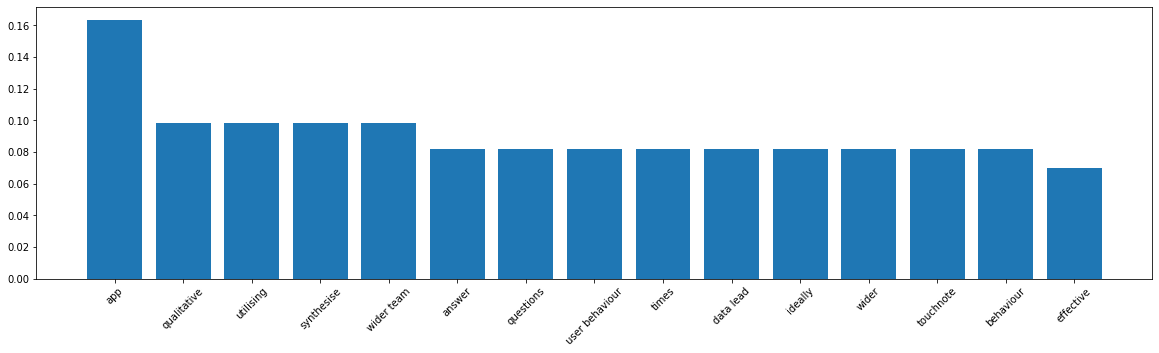

common words in cluster 7:


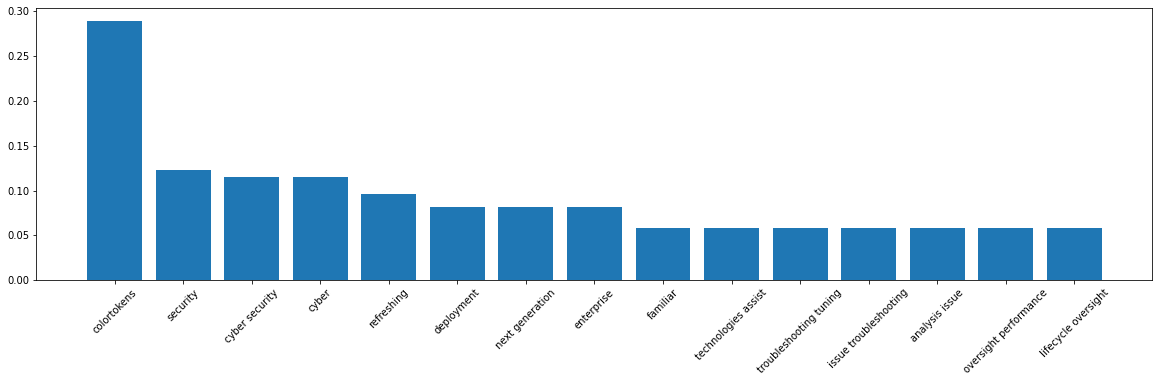

In [57]:
plot_important_terms_in_clusters_using_tfidf('clusters_transformers', 7)

In [79]:
df_jobs['clusters_RNN_Glove_Bert_Flair'].value_counts()

0    190
1    114
6     67
4     43
3     43
2     26
5     19
Name: clusters_RNN_Glove_Bert_Flair, dtype: int64

In [64]:
df_jobs['clusters_transformers'].value_counts()

1    168
0    134
2     75
4     43
5     38
6     25
3     19
Name: clusters_transformers, dtype: int64

**Clusters formed on Transformers embeddings contain the below  information,**

**1) cluster 1: analytics in general using terms like power bi, tableau, dashboards, analyst mostly in oil and gas, metals domain**

**2) cluster 5: data mining and various tools like rapidminer, sas, cassandra, oracle, microsoft and some programming languages like python and java**

**3) cluster 7: security, cyber security, deployment, troubleshooting issue, analysing issue, oversign performance**

**Overall the clustering formed on the Glove+Flair embeddings are much better compared to the Transformers embeddings. But there are overlapping in some clusters. Lets further break down the clusters**

**Set the number of clusters as 12**

In [ ]:
N_CLUSTERS = 12
# WARD CLUSTER
import ast

ward = AgglomerativeClustering(n_clusters=N_CLUSTERS,
                               affinity='euclidean',
                               linkage='ward')
pred_ward_rnn_glove_bert_flair = ward.fit_predict([ast.literal_eval(df_jobs['embeddings_RNN_Glove_Bert_Flair'][ind]) for ind in df_jobs.index])
df_jobs['clusters_RNN_Glove_Bert_Flair12'] = pred_ward_rnn_glove_bert_flair

In [ ]:
pred_ward_transformers = ward.fit_predict([ast.literal_eval(df_jobs['embeddings_transformers'][ind]) for ind in df_jobs.index])
df_jobs['clusters_transformers12'] = pred_ward_transformers

common words in cluster 1:


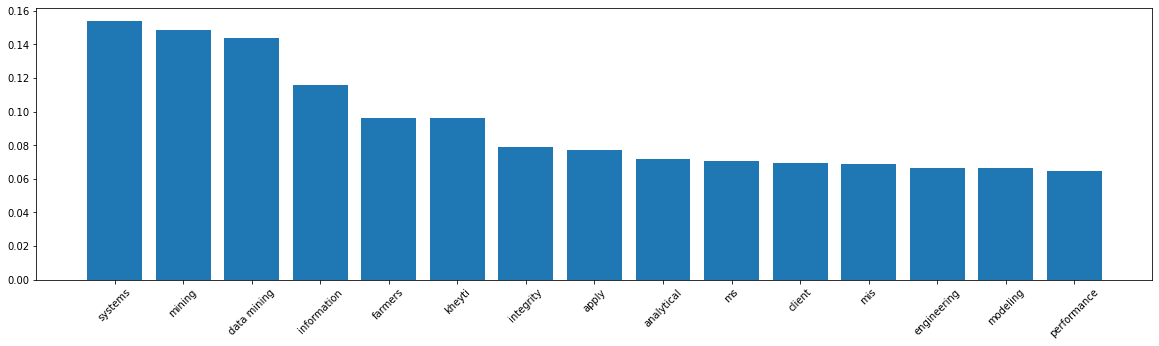

common words in cluster 2:


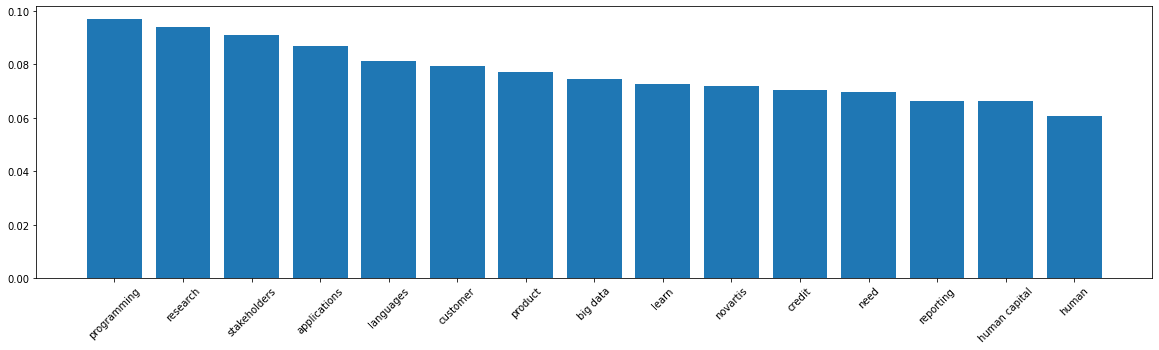

common words in cluster 3:


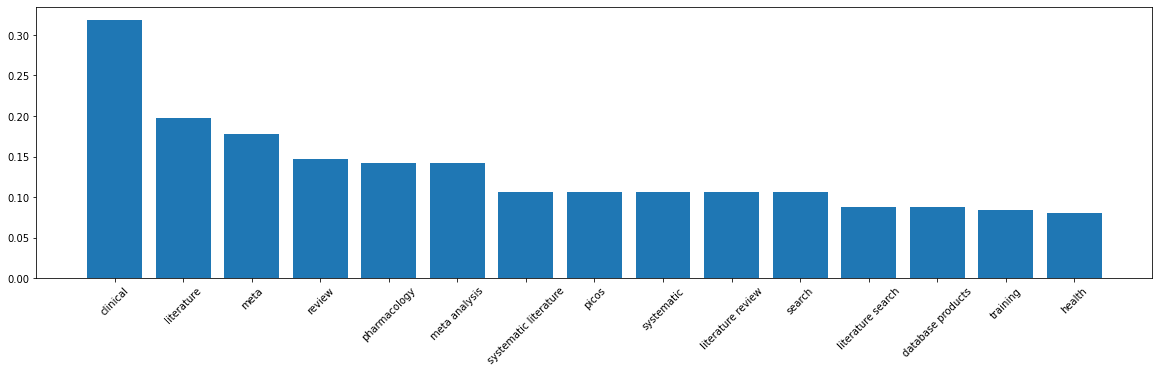

common words in cluster 4:


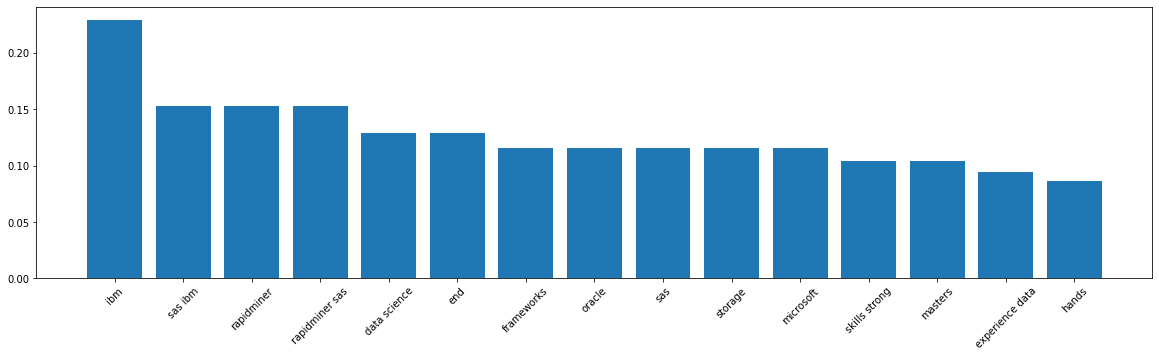

common words in cluster 5:


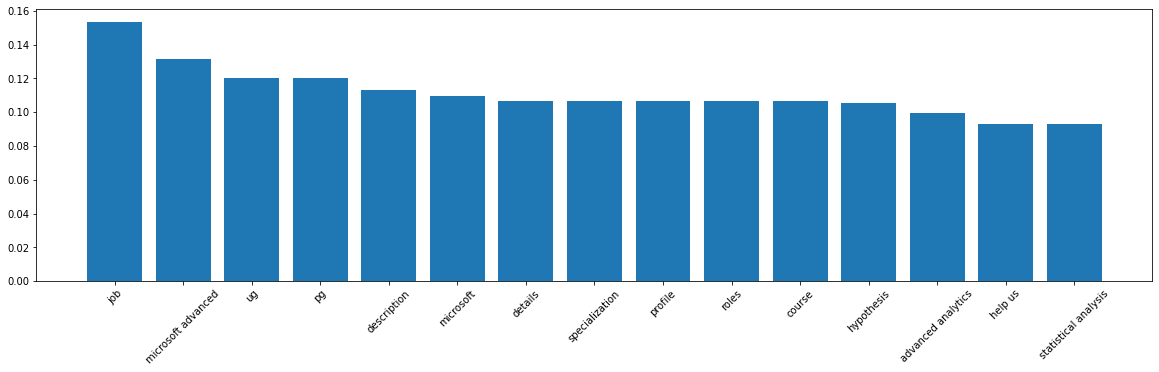

common words in cluster 6:


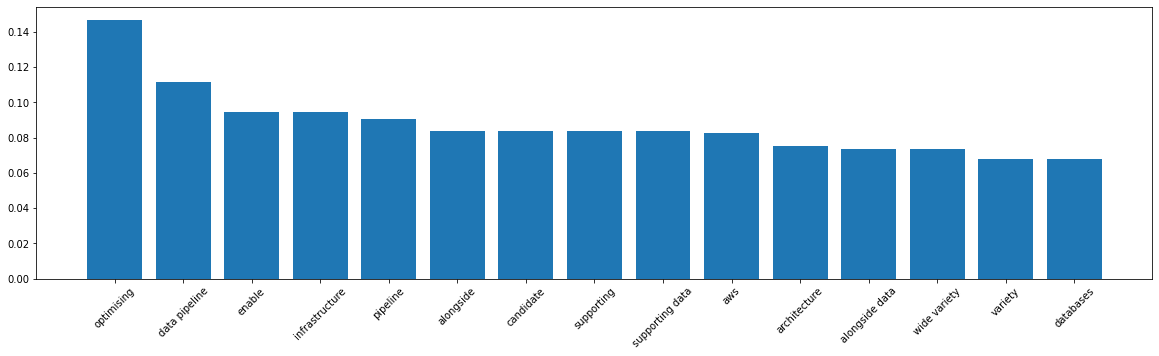

common words in cluster 7:


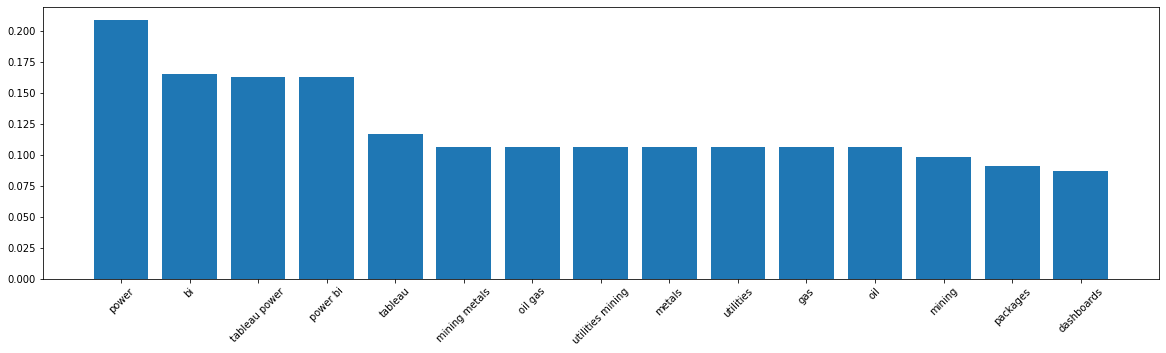

common words in cluster 8:


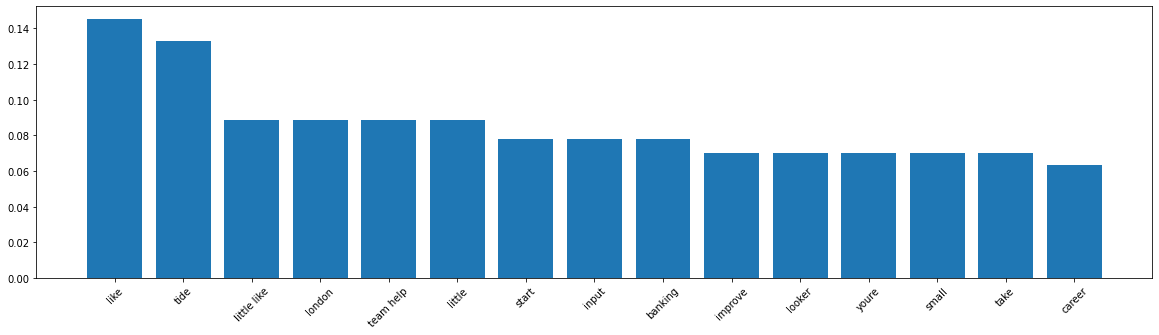

common words in cluster 9:


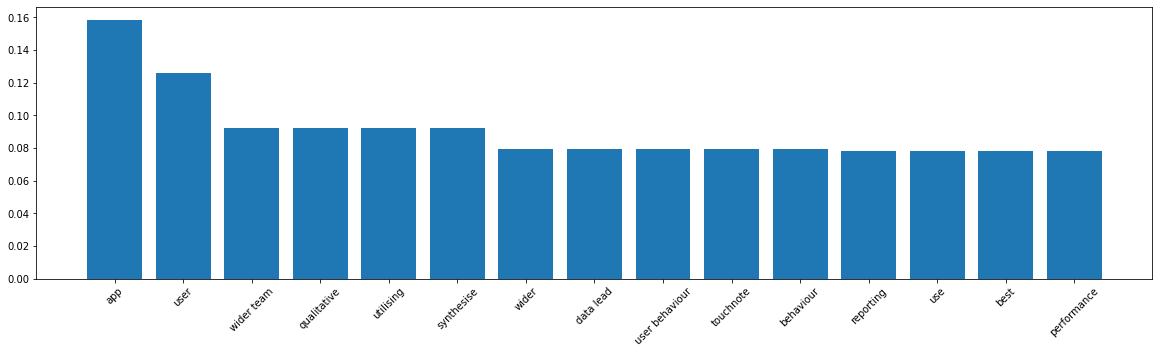

common words in cluster 10:


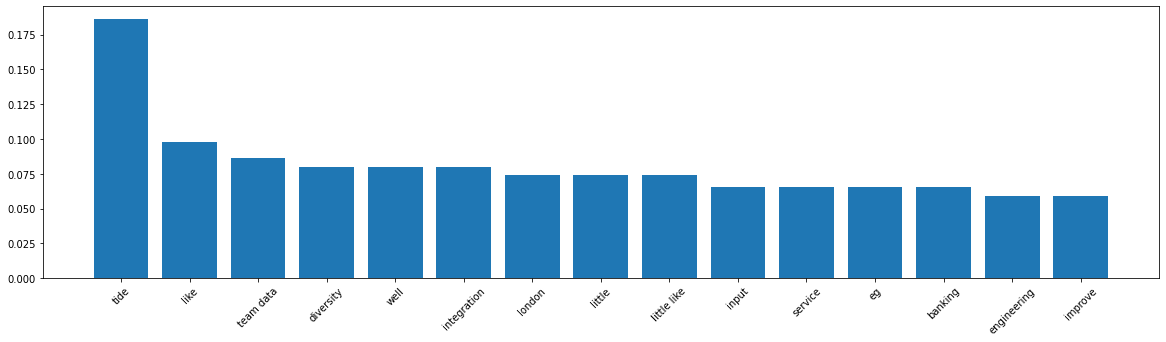

common words in cluster 11:


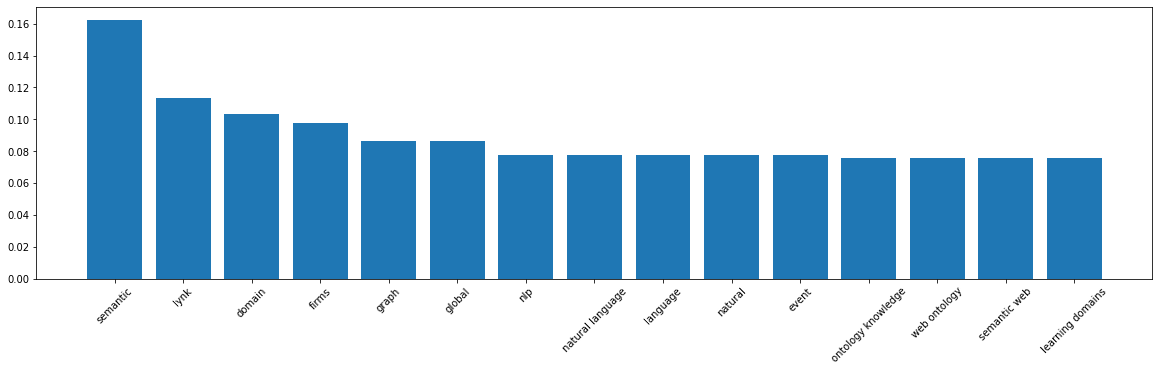

common words in cluster 12:


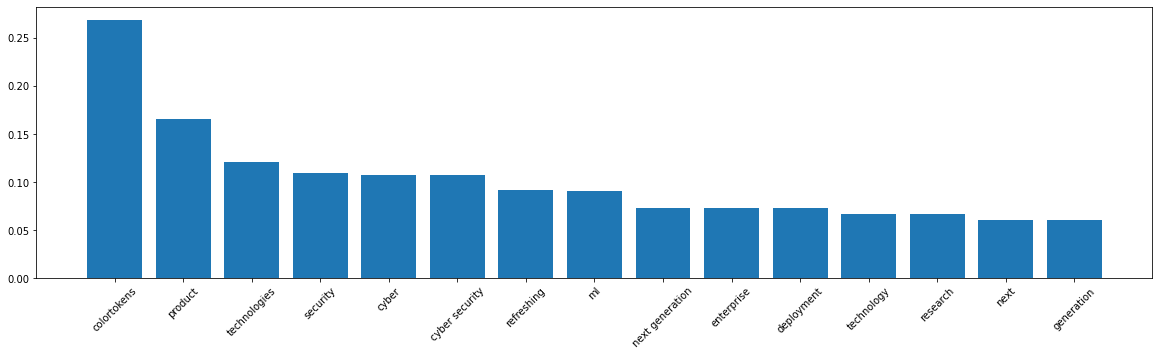

In [87]:
plot_important_terms_in_clusters_using_tfidf('clusters_RNN_Glove_Bert_Flair12', 12)

**As we can see, by increasing the number of clusters to 12, we have managed to get 2 more meaningfull clusters in addition to the previous 4.**

**The two new clusters added are:**

**1) cluster 12: cyber security, deployment, next generation technologies**

**2) cluster 11: nlp, natural language processing, semantic graph, ontology**

In [ ]:
df_jobs.to_csv("job_clustering_final.csv", encoding="utf-8")